In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121
from keras import Model
from keras.layers.experimental import preprocessing
from keras.models import Sequential

# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# import itertools

2024-07-01 02:41:43.667574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 02:41:43.667607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 02:41:43.668418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 02:41:43.674088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [5]:
# Đường dẫn đến thư mục chứa dataset
data_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
1,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
2,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
3,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
4,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
...,...,...
21150,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21151,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21152,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21153,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle


[17770   921 13656 14684 18899 20880  4273 18777  9684 13363 16829 10720
  8382 20932 15062  9942]


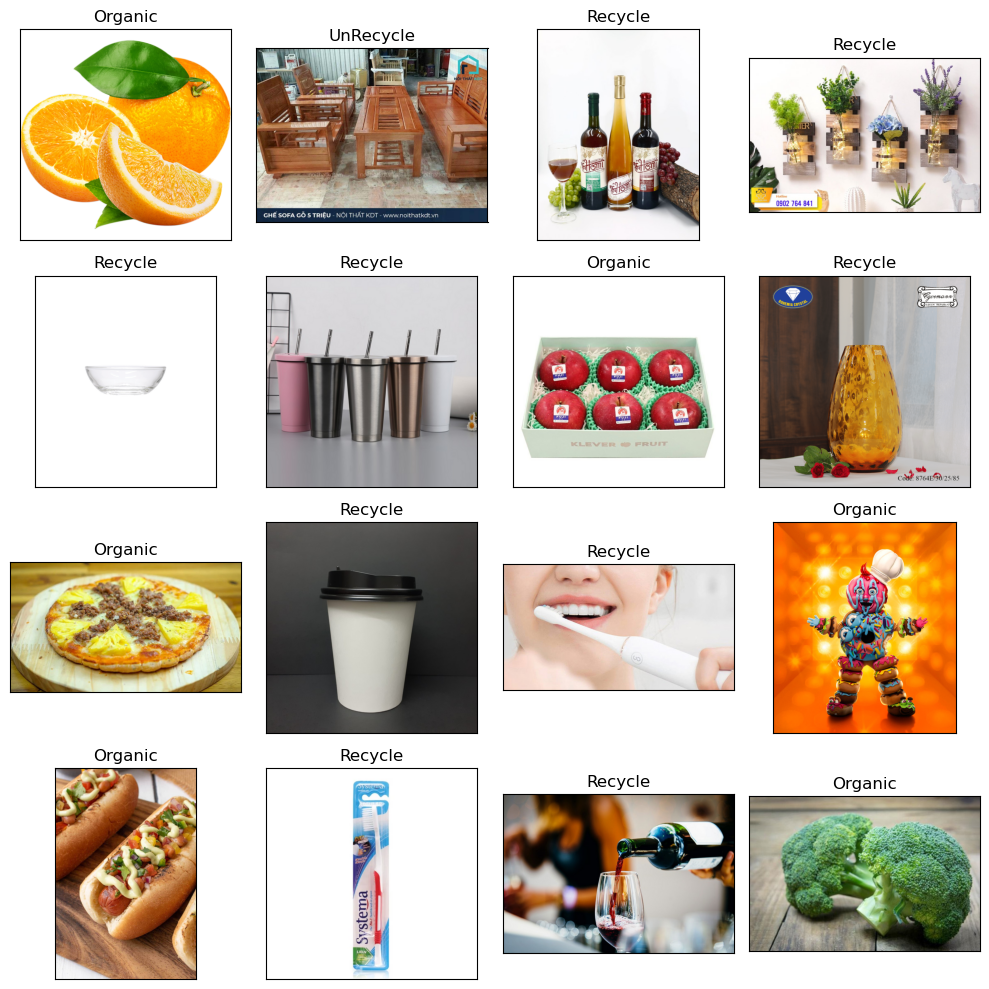

In [7]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape
test_df.shape

(4231, 2)

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [10]:
import os

# Định nghĩa các tham số cho dataset
batch_size = 32
img_size = (200, 200)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [11]:
print(train_images.classes[0:10])

[1, 0, 1, 2, 0, 0, 1, 1, 0, 1]


In [12]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2024-07-01 02:41:47.365614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 02:41:47.365884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 02:41:47.424536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
pretrained_model=tf.keras.applications.resnet.ResNet101(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

In [14]:
pretrained_model.trainable = False

In [15]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 50,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [16]:
inputs=pretrained_model.inputs
x = resize_and_rescale(inputs)
x=Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)

In [17]:
model=Model(inputs,outputs)

In [18]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=200,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bag_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240701-024150


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


2024-07-01 02:41:54.441877: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-01 02:41:57.158743: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2b78e345b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 02:41:57.158781: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-07-01 02:41:57.158792: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-01 02:41:57.167215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719801717.262098 2896229 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 [==============================] - 144s 323ms/step - loss: 0.1648 - accuracy: 0.9421 - val_loss: 0.0639 - val_accuracy: 0.9784
Epoch 2/200
424/424 [==============================] - 128s 302ms/step - loss: 0.0555 - accuracy: 0.9817 - val_loss: 0.0575 - val_accuracy: 0.9808
Epoch 3/200
424/424 [==============================] - 129s 304ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0459 - val_accuracy: 0.9852
Epoch 4/200
424/424 [==============================] - 132s 312ms/step - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.0412 - val_accuracy: 0.9861
Epoch 5/200
424/424 [==============================] - 132s 312ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0461 - val_accuracy: 0.9855
Epoch 6/200
424/424 [==============================] - 137s 322ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0437 - val_accuracy: 0.9870
Epoch 7/200
424/424 [==============================] - 133s 314ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0488 - val_

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [20]:
history.history

{'loss': [0.16478997468948364,
  0.05553650110960007,
  0.0368359312415123,
  0.02376345358788967,
  0.014306643977761269,
  0.010089552029967308,
  0.006816374137997627,
  0.0048557789996266365,
  0.004556562285870314,
  0.005072222091257572,
  0.002096876734867692,
  0.003747697453945875,
  0.003712967736646533,
  0.0027625137008726597,
  0.0011768789263442159,
  0.0015866286121308804,
  0.00426789466291666,
  0.002375961048528552,
  0.0010508006671443582,
  0.0015890465583652258,
  0.0005402102251537144,
  0.0005586350453086197,
  0.0007329856744036078,
  0.0011412777239456773,
  0.00899224542081356,
  0.001270991750061512,
  0.0008969021728262305,
  0.0005095358355902135,
  0.00013412736007012427,
  0.0006377602112479508,
  0.0009493602556176484,
  0.00289011187851429,
  0.0018475829856470227,
  0.0008909215684980154,
  0.000543098256457597,
  0.0002872807963285595,
  0.0025476713199168444,
  0.0031697857193648815,
  0.0011071799090132117,
  0.00034535114536993206,
  8.189482468878

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02889
Test Accuracy: 99.03%


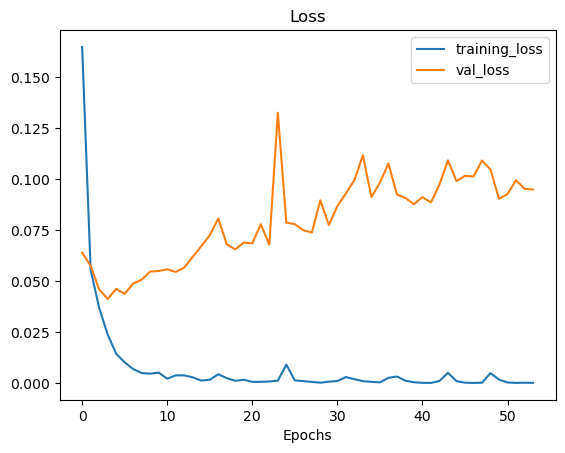

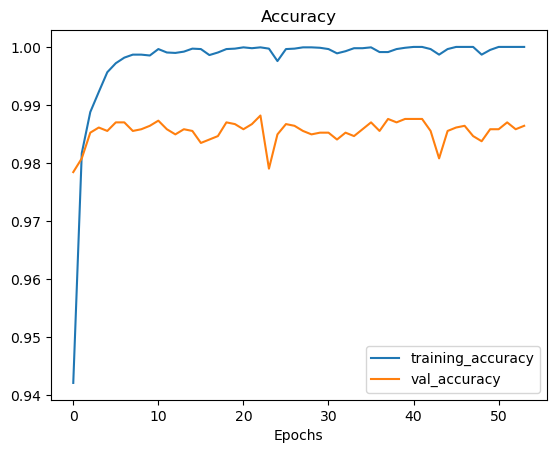

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [23]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

133/133 [==============================] - 37s 267ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


SyntaxError: not a PNG file (<string>)

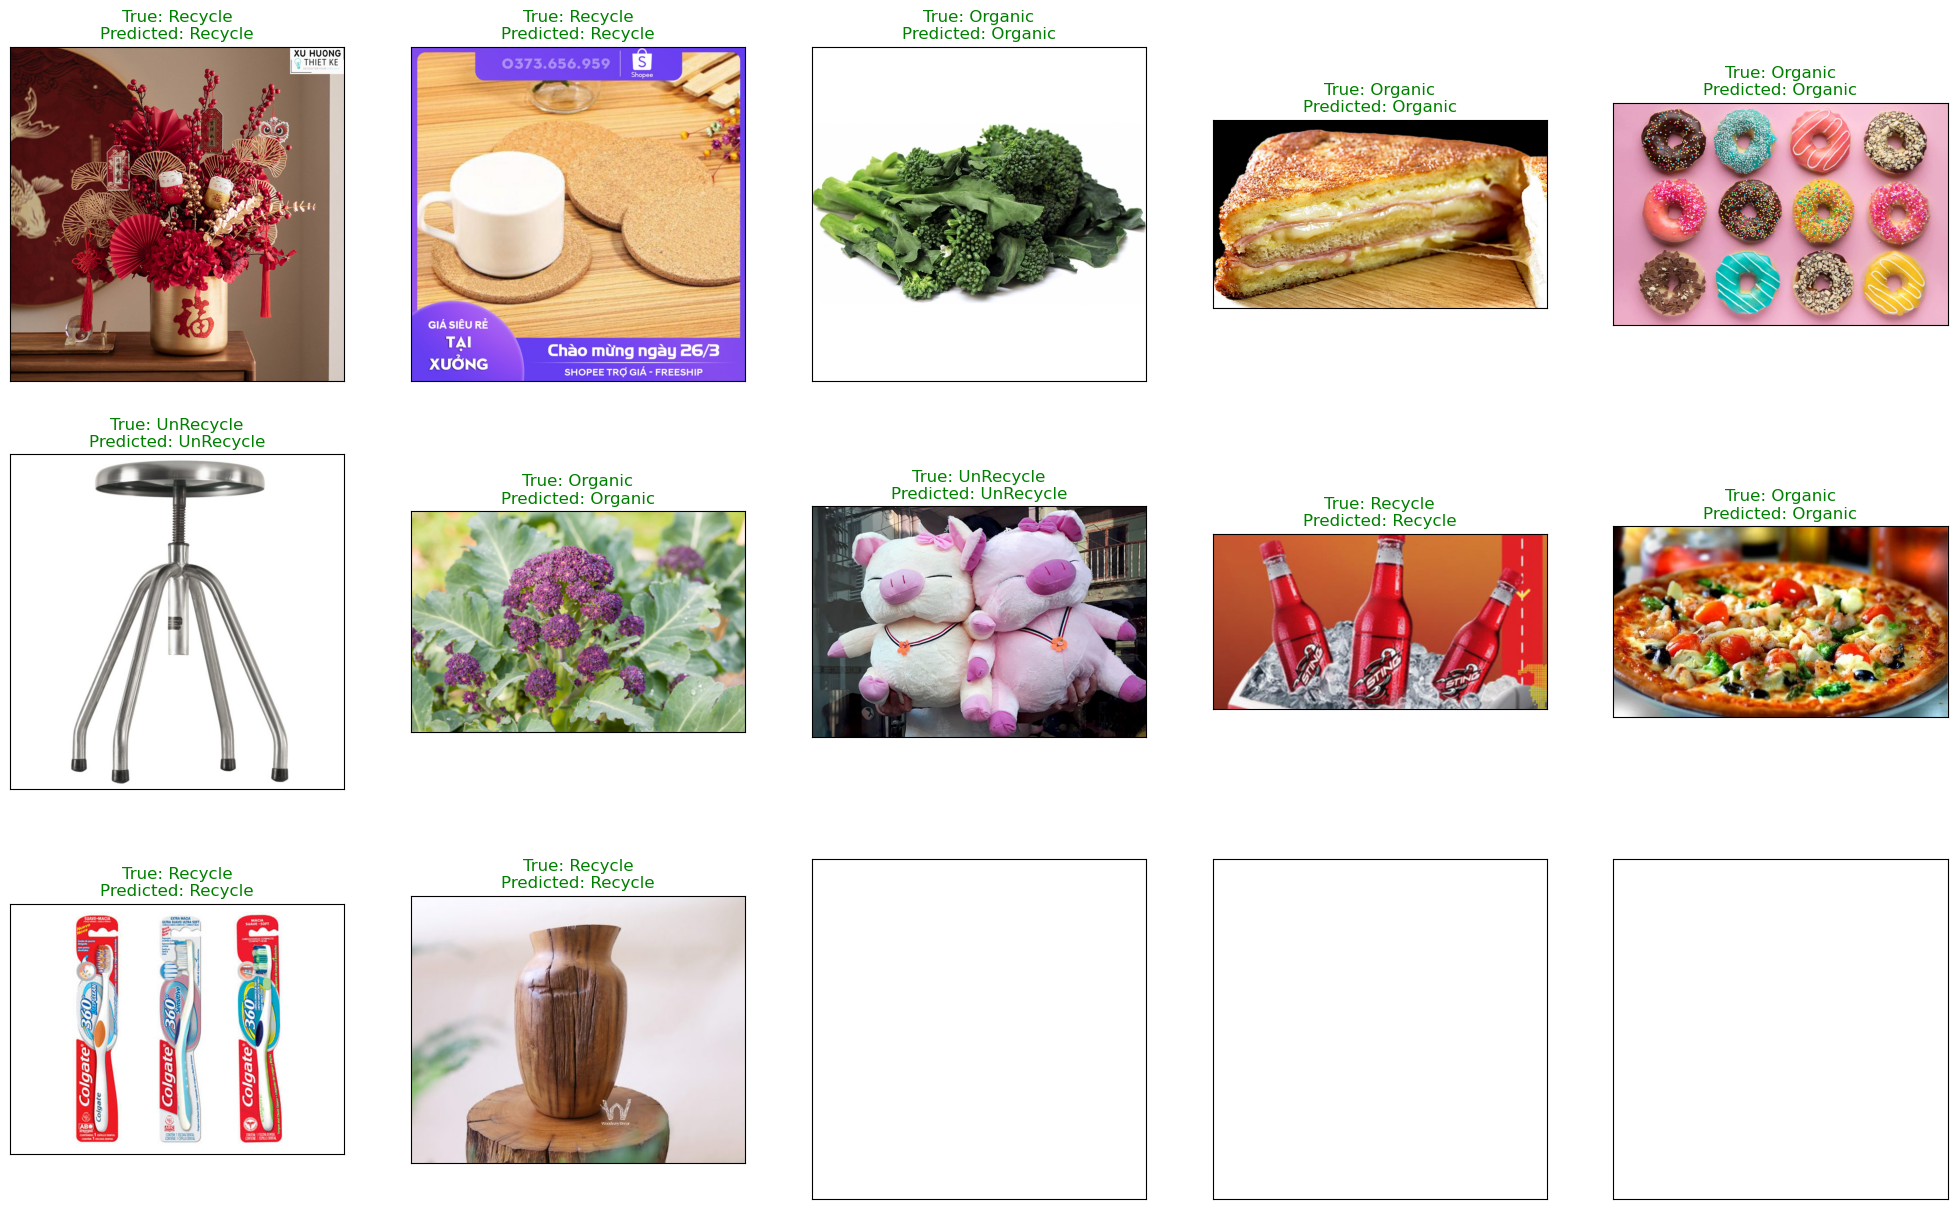

In [24]:
# random_index = np.random.randint(0, len(test_df) - 1, 15)
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
#     if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
#         color = "green"
#     else:
#         color = "red"
#     ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
# plt.show()
# plt.tight_layout()

In [25]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.993247,0.991016,0.992130,1781.00000
Recycle,0.988875,0.987045,0.987959,1621.00000
UnRecycle,0.986842,0.995175,0.990991,829.00000
accuracy,0.990310,0.990310,0.990310,0.99031
macro avg,0.989655,0.991079,0.990360,4231.00000
weighted avg,0.990317,0.990310,0.990309,4231.00000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()